Training Batches: 100%|██████████| 40/40 [02:05<00:00,  3.13s/batch]


✅ Training Complete!


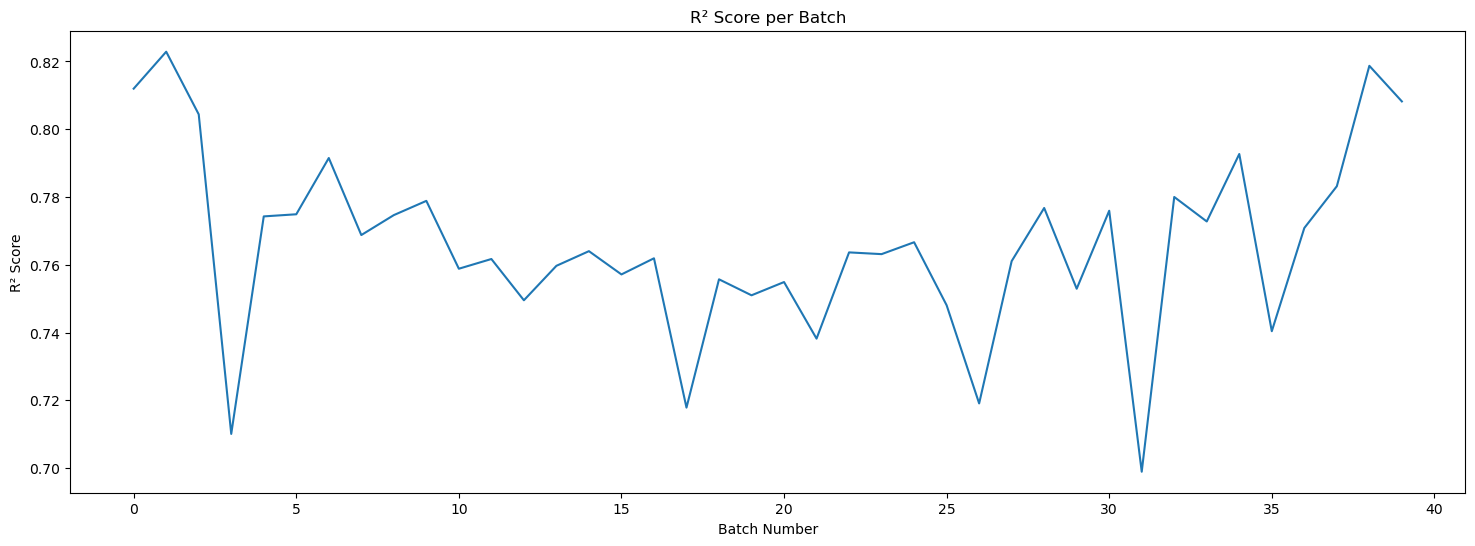

In [1]:
import polars as pl
import sys
sys.path.append('..')
from configs.data_configs import PROCESSED_FILE_LIST

from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize the model and scaler
model = SGDRegressor()
scaler = StandardScaler()

# Create the pipeline with model and scaler
pipe = Pipeline([
    ('scaler', scaler),
    ('model', model)
])

r2_scores = []
# Flag to check if the scaler is fitted
scaler_fitted = False

# Train on batches
for current_file in tqdm(PROCESSED_FILE_LIST, total=len(PROCESSED_FILE_LIST), desc="Training Batches", unit="batch"):
    # Load batch
    current_batch = pl.read_parquet(current_file)
    X_batch = current_batch.drop("trip_time").to_pandas()
    y_batch = current_batch['trip_time'].to_pandas()    
    
    if not scaler_fitted:
        # Fit scaler on first batch, and set the flag
        X_batch = scaler.fit_transform(X_batch)
        scaler_fitted = True
    else:
        # Transform subsequent batches with fitted scaler
        X_batch = scaler.transform(X_batch)
    
    # Partial fit on the batch data
    model.partial_fit(X_batch, y_batch)

    # Predict and evaluate
    y_pred = model.predict(X_batch)
    mse = mean_squared_error(y_batch, y_pred)
    r2 = r2_score(y_batch, y_pred)
    r2_scores.append(r2)

print("✅ Training Complete!")

# Plotting the R² scores
plt.figure(figsize=(18, 6))
plt.plot(r2_scores[:])
plt.xlabel("Batch Number")
plt.ylabel("R² Score")
plt.title("R² Score per Batch")
plt.show()

In [ ]:
import joblib

joblib.dump(model, '../models/linear_regression_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
print("✅ Model and Scaler Saved!")
model = joblib.load('../models/linear_regression_model.pkl')
scaler = joblib.load('../models/scaler.pkl')

# Example Test Batch
X_test = pl.read_parquet('../processed_data/features/X_batch_1.parquet').to_pandas()
y_test = pl.read_parquet('../processed_data/lables/y_batch_1.parquet').to_pandas().squeeze()

# Scale Test Data
X_test = scaler.transform(X_test)

# Predict
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 Mean Squared Error: {mse}")
print(f"📈 R^2 Score: {r2}")

Training Batches: 100%|██████████| 40/40 [00:54<00:00,  1.37s/batch]


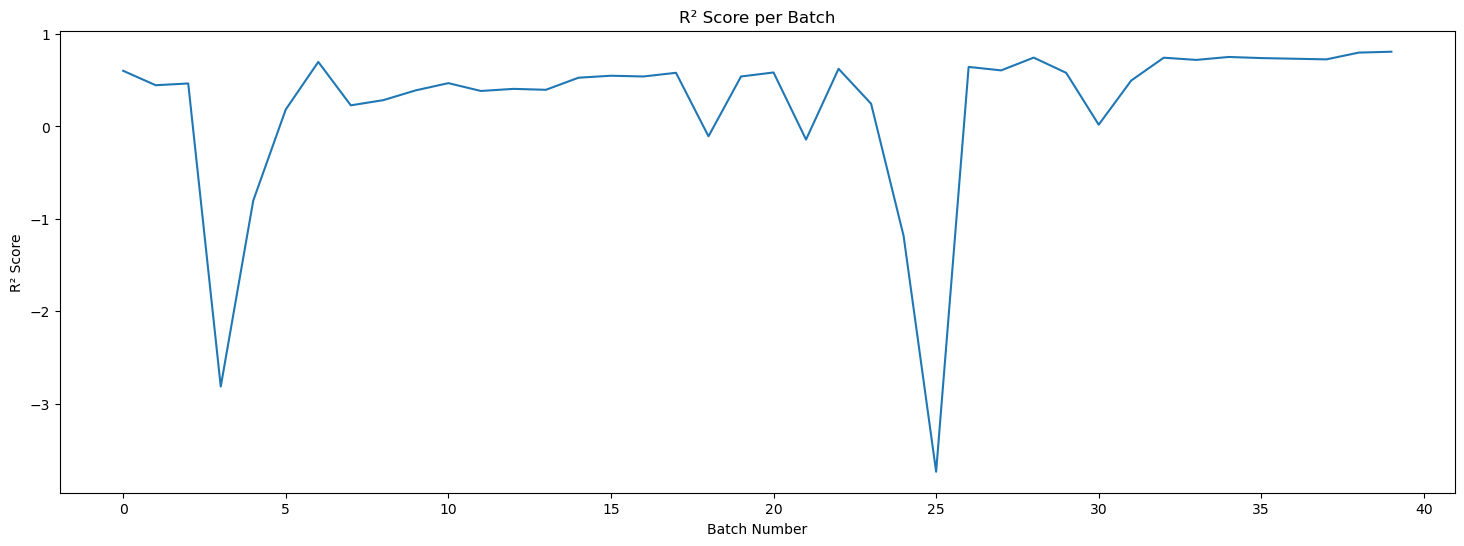

In [2]:
r2_scores = []

# Train on batches
for current_file in tqdm(PROCESSED_FILE_LIST, total=len(PROCESSED_FILE_LIST), desc="Training Batches", unit="batch"):

    # Load batch
    current_batch = pl.read_parquet(current_file)
    X_batch = current_batch.drop("trip_time").to_pandas()
    y_batch = current_batch['trip_time'].to_pandas()    
    
    # Scale features
    X_batch = scaler.fit_transform(X_batch) if not hasattr(scaler, 'mean_') else scaler.transform(X_batch)

    # Predict
    y_pred = model.predict(X_batch)

    # Evaluate
    from sklearn.metrics import mean_squared_error, r2_score

    mse = mean_squared_error(y_batch, y_pred)
    r2 = r2_score(y_batch, y_pred)
    r2_scores.append(r2)

import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))
plt.plot(r2_scores[:])
plt.xlabel("Batch Number")
plt.ylabel("R² Score")
plt.title("R² Score per Batch")
plt.show()